# 将图片中的object切出然后推理
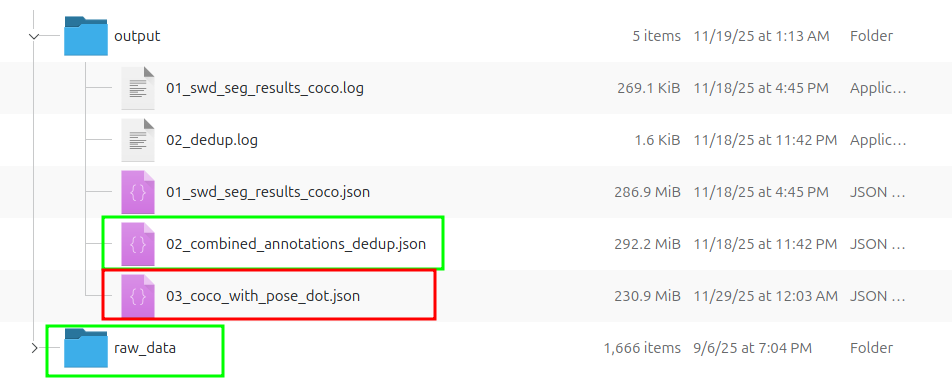
```json
{
    "info": {
        "description": "SWD COCO format instance segmentation with pose and dot annotations",
        "version": "1.0",
        "year": 2025,
        "contributor": "Tianqi Yao",
    },
    "licenses": [
        {
            "id": 1, 
            "name": "CC BY-NC 4.0",
            "url": "https://creativecommons.org/licenses/by-nc/4.0/"
        }
    ],
    "images": [
        {
            "id": 100,
            "file_name": "0730_1834_760.jpg",
            "width": 640,
            "height": 480,
            "license": 1,
            "date_captured": "2024-07-30T18:34:00-05:00",  // ISO 8601 format, US central time
            "focal_length_parameter": 760
        }
    ],
    "annotations": [
        {
            "id": 1,
            "image_id": 100,
            "category_id": 1,
            "object_id": "", // UUID string
            "score": 0.92,
            "segmentation": [[x1, y1, x2, y2, ...]],  // pixel coordinates
            "area": 1032.0,
            "bbox": [x, y, width, height],  //  pixel coordinates
            "iscrowd": 0,
            "keypoints": [x1, y1, v1, x2, y2, v2, x3, y3, v3], // v=0: not labeled, v=1: labeled but not visible, v=2: labeled and visible
            "num_keypoints": 3,
            "attributes": {
                "dot_detections": [
                    {
                        "bbox": [x1, y1, w1, h1],  // pixel coordinates
                        "score": 0.95,
                        "category_id": 2,
                    },
                    {
                        "bbox": [x2, y2, w2, h2],  // pixel coordinates
                        "score": 0.87,
                        "category_id": 2,
                    }
                ]
            }
        }
    ],
    "categories": [
        {
            "id": 1,
            "name": "swd",
            "supercategory": "object",
            "keypoints": ["h", "lp", "rp"],
            "skeleton": [[0, 1], [0, 2]]
        },
        {
            "id": 2,
            "name": "dot", 
            "supercategory": "object"
        }
    ]
}
```

In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

"""
主脚本：硬编码 YAML 路径（KISS）
运行方式： python pose_dot_main.py
"""

from __future__ import annotations

import json
import logging
from dataclasses import dataclass
from pathlib import Path
from typing import Any, Dict, List, Tuple

import cv2
import numpy as np
import yaml
from ultralytics import YOLO

from datetime import datetime
from zoneinfo import ZoneInfo


# ============================ 硬编码 YAML 路径 ============================

CONFIG_PATH = Path("config/03_config.yaml")   # ← 你想写什么就写什么


# ============================ 数据类 ============================

@dataclass
class ModelArgs:
    imgsz: Any = None
    conf: float = 0.5
    iou: float = 0.5
    device: int = 0
    batch: int = 1
    verbose: bool = False


@dataclass
class CropConfig:
    margin: int
    kpt_names: List[str]


@dataclass
class PathsConfig:
    data_root: Path
    target_subdir_name: Path
    depth: int
    input_json_rel: Path
    output_json_rel: Path
    log_file_name: str


@dataclass
class CategoriesConfig:
    swd: Dict[str, Any]
    dot: Dict[str, Any]


@dataclass
class PipelineConfig:
    paths: PathsConfig
    pose_model_path: Path
    dot_model_path: Path
    pose_args: ModelArgs
    dot_args: ModelArgs
    crop: CropConfig
    categories: CategoriesConfig
    free_gpu_after_each_dir: bool
    timezone: str


# ============================ logger ============================

LOGGER = logging.getLogger("pose_dot")


def configure_logging_for_directory(base_dir: Path, log_file_name: str, level: str, tz: ZoneInfo):
    base_dir.mkdir(parents=True, exist_ok=True)
    log_path = base_dir / log_file_name

    log_level = getattr(logging, level.upper(), logging.INFO)
    LOGGER.setLevel(log_level)

    def _custom_time(*args):
        return datetime.now(tz).timetuple()

    logging.Formatter.converter = _custom_time

    fmt = logging.Formatter(fmt="%(asctime)s [%(levelname)s] %(message)s", datefmt="%Y-%m-%d %H:%M:%S")

    for handler in LOGGER.handlers[:]:
        LOGGER.removeHandler(handler)
        handler.close()

    console_handler = logging.StreamHandler()
    console_handler.setLevel(log_level)
    console_handler.setFormatter(fmt)

    file_handler = logging.FileHandler(log_path, mode="w", encoding="utf-8")
    file_handler.setLevel(log_level)
    file_handler.setFormatter(fmt)

    LOGGER.addHandler(console_handler)
    LOGGER.addHandler(file_handler)

    LOGGER.info("Logging configured for %s", base_dir)
    LOGGER.info("Log file: %s", log_path)


# ============================ 工具 ============================

def free_gpu():
    try:
        import gc, torch
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            torch.cuda.ipc_collect()
    except Exception as e:
        LOGGER.warning("free_gpu failed: %s", e)


def _fix_imgsz(model: YOLO, imgsz):
    if imgsz is None:
        ms = model.overrides.get("imgsz", None)
        return 640 if ms is None else ms
    return imgsz


def fetch_subsequent_dir(data_root: Path, target_subdir_name: Path, depth: int):
    pattern = f"{'*/' * depth}{target_subdir_name}"
    data_paths = list(data_root.glob(pattern))
    subdirs = [p.parent for p in data_paths]
    names = [p.name for p in subdirs]
    return subdirs, names


# ============================ 推理（保持 KISS） ============================

def run_pose_on_crop(model, crop_img, kpt_names, args):
    results = model.predict(source=crop_img, **args)
    if not results:
        return {"instances": []}

    res = results[0]
    boxes = getattr(res, "boxes", None)
    bbox_conf = boxes.conf.cpu().numpy() if (boxes and boxes.conf is not None) else None

    kpts = getattr(res, "keypoints", None)
    if kpts is None or kpts.data is None:
        return {"instances": []}

    arr = kpts.data.cpu().numpy()
    conf_arr = kpts.conf.cpu().numpy() if getattr(kpts, "conf", None) is not None else None

    instances = []

    for idx in range(arr.shape[0]):
        pts = arr[idx]
        kps = []
        scores = []
        num = 0

        for ki in range(min(len(kpt_names), pts.shape[0])):
            x, y = float(pts[ki][0]), float(pts[ki][1])
            conf = float(conf_arr[idx][ki]) if conf_arr is not None else None
            vis = 2 if (conf and conf > 0.5) else 1

            kps.extend([x, y, vis])
            scores.append(conf)
            if vis == 2:
                num += 1

        bbox_score = float(bbox_conf[idx]) if bbox_conf is not None else None

        instances.append(
            dict(
                keypoints=kps,
                num_keypoints=num,
                pose_bbox_score=bbox_score,
                pose_keypoint_score=scores,
            )
        )

    return {"instances": instances}


def run_dot_on_crop(model, crop_img, args):
    results = model.predict(source=crop_img, **args)
    if not results:
        return {"dot_detections": []}

    res = results[0]
    boxes = res.boxes
    if boxes is None or not hasattr(boxes, "xywh"):
        return {"dot_detections": []}

    xywh = boxes.xywh.cpu().numpy()
    conf = boxes.conf.cpu().numpy()

    dots = []
    for i in range(xywh.shape[0]):
        x, y, w, h = xywh[i]
        dots.append(
            dict(
                bbox=[float(x - w / 2), float(y - h / 2), float(w), float(h)],
                score=float(conf[i]),
                category_id=2,
            )
        )
    return {"dot_detections": dots}


def point_in_box(px, py, box):
    x, y, w, h = box
    return x <= px <= x + w and y <= py <= y + h


def mark_final_swd(ann):
    kps = ann.get("keypoints", [])
    if len(kps) < 9:
        ann.setdefault("attributes", {})["is_final_swd"] = False
        return

    lp_x, lp_y = kps[3], kps[4]
    rp_x, rp_y = kps[6], kps[7]
    dots = ann.setdefault("attributes", {}).get("dot_detections", [])

    lp_hit = any(point_in_box(lp_x, lp_y, d["bbox"]) for d in dots)
    rp_hit = any(point_in_box(rp_x, rp_y, d["bbox"]) for d in dots)

    ann["attributes"]["is_final_swd"] = bool(lp_hit and rp_hit)


# ============================ COCO - 主逻辑 ============================

def attach_pose_dot(
    coco_json_path,
    images_root,
    output_json_path,
    pose_model_path,
    dot_model_path,
    pose_cfg,
    dot_cfg,
    crop_cfg,
    categories_cfg,
):
    if not coco_json_path.exists():
        LOGGER.warning("Missing COCO JSON: %s", coco_json_path)
        return

    with coco_json_path.open("r", encoding="utf-8") as f:
        coco = json.load(f)

    images = coco["images"]
    annotations = coco["annotations"]

    # image → anns
    anns_by_img = {}
    for ann in annotations:
        anns_by_img.setdefault(ann["image_id"], []).append(ann)

    LOGGER.info("Loading pose model")
    pose_model = YOLO(str(pose_model_path))
    pose_args = dict(
        imgsz=_fix_imgsz(pose_model, pose_cfg.imgsz),
        conf=pose_cfg.conf,
        iou=pose_cfg.iou,
        device=pose_cfg.device,
        batch=pose_cfg.batch,
        verbose=pose_cfg.verbose,
    )

    LOGGER.info("Loading dot model")
    dot_model = YOLO(str(dot_model_path))
    dot_args = dict(
        imgsz=_fix_imgsz(dot_model, dot_cfg.imgsz),
        conf=dot_cfg.conf,
        iou=dot_cfg.iou,
        device=dot_cfg.device,
        batch=dot_cfg.batch,
        verbose=dot_cfg.verbose,
    )

    for img_info in images:
        img_id = img_info["id"]
        fname = img_info["file_name"]

        img_path = images_root / fname
        img = cv2.imread(str(img_path))
        if img is None:
            LOGGER.warning("Image read failed: %s", img_path)
            continue

        anns = anns_by_img.get(img_id, [])
        LOGGER.info("Image %s: %d objects", fname, len(anns))

        h, w = img.shape[:2]

        for ann in anns:
            x, y, bw, bh = ann["bbox"]
            m = crop_cfg.margin

            x1 = max(0, int(x - m))
            y1 = max(0, int(y - m))
            x2 = min(w, int(x + bw + m))
            y2 = min(h, int(y + bh + m))

            crop = img[y1:y2, x1:x2]

            # pose
            pose_res = run_pose_on_crop(pose_model, crop, crop_cfg.kpt_names, pose_args)
            insts = pose_res["instances"]
            insts.sort(key=lambda d: d.get("pose_bbox_score") or 0, reverse=True)

            best = (
                insts[0]
                if insts
                else dict(keypoints=[], num_keypoints=0, pose_bbox_score=None, pose_keypoint_score=[])
            )

            kps = best["keypoints"].copy()
            for i in range(0, len(kps), 3):
                kps[i] += x1
                kps[i + 1] += y1

            ann["keypoints"] = kps
            ann["num_keypoints"] = best["num_keypoints"]
            ann["pose_confidence"] = best["pose_keypoint_score"]
            ann["pose_bbox_score"] = best["pose_bbox_score"]

            # dot
            dot_res = run_dot_on_crop(dot_model, crop, dot_args)
            global_dots = []
            for d in dot_res["dot_detections"]:
                dx, dy, dw, dh = d["bbox"]
                global_dots.append(
                    dict(
                        bbox=[dx + x1, dy + y1, dw, dh],
                        score=d["score"],
                        category_id=d["category_id"],
                    )
                )

            ann.setdefault("attributes", {})["dot_detections"] = global_dots

            mark_final_swd(ann)

    # 写 categories
    coco["categories"] = [categories_cfg.swd, categories_cfg.dot]

    output_json_path.parent.mkdir(parents=True, exist_ok=True)
    with output_json_path.open("w", encoding="utf-8") as f:
        json.dump(coco, f, indent=2, ensure_ascii=False)

    LOGGER.info("Saved result: %s", output_json_path)


# ============================ YAML 读取 ============================

def load_config():
    with CONFIG_PATH.open("r", encoding="utf-8") as f:
        cfg = yaml.safe_load(f)

    paths = PathsConfig(
        data_root=Path(cfg["data_root"]),
        target_subdir_name=Path(cfg["target_subdir_name"]),
        depth=cfg["depth"],
        input_json_rel=Path(cfg["output_files"]["input_json"]),
        output_json_rel=Path(cfg["output_files"]["output_json"]),
        log_file_name=cfg["output_files"]["log_file"],
    )

    pose_cfg = ModelArgs(**cfg["pose_args"])
    dot_cfg = ModelArgs(**cfg["dot_args"])
    crop_cfg = CropConfig(**cfg["crop"])
    categories_cfg = CategoriesConfig(**cfg["categories"])

    return PipelineConfig(
        paths=paths,
        pose_model_path=Path(cfg["models"]["pose_model"]),
        dot_model_path=Path(cfg["models"]["dot_model"]),
        pose_args=pose_cfg,
        dot_args=dot_cfg,
        crop=crop_cfg,
        categories=categories_cfg,
        free_gpu_after_each_dir=cfg["free_gpu_after_each_dir"],
        timezone=cfg["timezone"],
    )


# ============================ MAIN ============================

def main():
    cfg = load_config()
    tz = ZoneInfo(cfg.timezone)

    subdirs, names = fetch_subsequent_dir(
        cfg.paths.data_root,
        cfg.paths.target_subdir_name,
        cfg.paths.depth,
    )

    if not subdirs:
        print("[WARN] No subdirectories found!")
        return

    for subdir, name in zip(subdirs, names):
        configure_logging_for_directory(
            subdir,
            cfg.paths.log_file_name,
            "INFO",
            tz,
        )

        coco_json = subdir / cfg.paths.input_json_rel
        output_json = subdir / cfg.paths.output_json_rel
        images_root = subdir / cfg.paths.target_subdir_name

        LOGGER.info("=== Processing %s ===", name)

        attach_pose_dot(
            coco_json,
            images_root,
            output_json,
            cfg.pose_model_path,
            cfg.dot_model_path,
            cfg.pose_args,
            cfg.dot_args,
            cfg.crop,
            cfg.categories,
        )

        if cfg.free_gpu_after_each_dir:
            free_gpu()


if __name__ == "__main__":
    main()
